In [26]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
!pip install split-folders
import splitfolders

# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Dogs and cats/Dogs_and_Cats.zip'

# Extracting the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall("DaC")

In [29]:
# Getting count of images per each class

num_dogs = len(os.listdir("/content/DaC/Animal Images/dogs"))
print("Number of dogs images: ", num_dogs)

num_cats = len(os.listdir("/content/DaC/Animal Images/cats"))
print("Number of dogs images: ", num_cats)

Number of dogs images:  15002
Number of dogs images:  15060


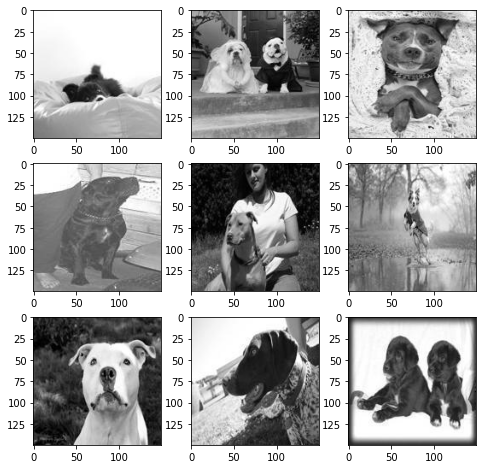

In [30]:
# Samples of dogs

picture_size = 150
folder_path = "/content/DaC/Animal Images/"

plt.figure(figsize= (8,8))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(folder_path + "dogs/" +
                  os.listdir(folder_path + "dogs")[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

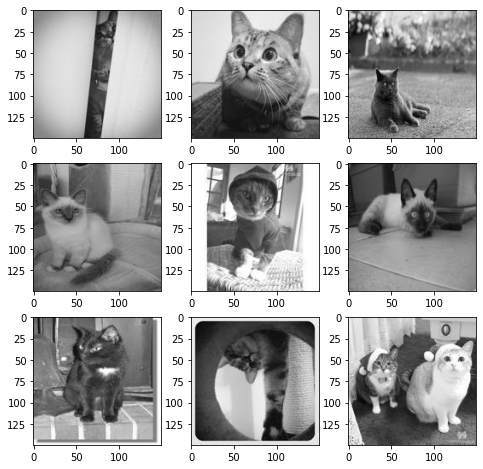

In [31]:
# Samples of cats

picture_size = 150
folder_path = "/content/DaC/Animal Images/"

plt.figure(figsize= (8,8))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(folder_path + "cats/" +
                  os.listdir(folder_path + "cats")[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

In [32]:
# Splitting the dataset into train, validation and test
input_folder = "/content/DaC/Animal Images"
splitfolders.ratio(input_folder, output ="DaC Dataset", seed=42, ratio=(.7, .2, .1), group_prefix=None)

Copying files: 30062 files [00:23, 1256.30 files/s]


In [33]:
# Genetrating training, validation and test data for GRAYSCALE images
img_size = 150
batch_size = 32

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)



train_set = datagen_train.flow_from_directory("/content/DaC Dataset/train",
                                              target_size = (img_size, img_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)

validation_set = datagen_validation.flow_from_directory("/content/DaC Dataset/val",
                                              target_size = (img_size, img_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)

test_set = datagen_test.flow_from_directory("/content/DaC Dataset/test",
                                              target_size = (img_size, img_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)

Found 21042 images belonging to 2 classes.
Found 6012 images belonging to 2 classes.
Found 3007 images belonging to 2 classes.


In [34]:
# Initializing the Sequential Model
model1 = Sequential()

# Adding the first Convolutional block
model1.add(Conv2D(64, (2, 2), padding="same", activation="relu", input_shape=(150, 150, 1))) 
model1.add(MaxPooling2D(2, 2))
model1.add(Dropout(0.2))

# Adding the second Convolutional block
model1.add(Conv2D(32, (2, 2), padding="same", activation="relu")) 
model1.add(MaxPooling2D(2, 2))
model1.add(Dropout(0.2))

# Adding the third Convolutional block
model1.add(Conv2D(32, (2, 2), padding="same", activation="relu")) 
model1.add(MaxPooling2D(2, 2))
model1.add(Dropout(0.2))

# Adding the Flatten layerm
model1.add(Flatten())

# Adding the first Dense layer and the dropoutlayer
model1.add(Dense((512), activation="relu"))
model1.add(Dropout(0.4))

# Adding the Final layer
model1.add(Dense((2), activation="softmax"))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 64)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        8224      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 37, 37, 32)       

In [35]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model1.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

In [36]:
# Compiling your model1 using categorical crossentropy as loss function, Adam Optimizer with 0.001 learning rate, and metrics 'accuracy'. 

optimizer = Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [37]:
# Fitting model1
history1 = model1.fit(train_set, validation_data= validation_set, epochs=20)

Epoch 1/20
658/658 [==============================] - 117s 171ms/step - loss: 0.6944 - accuracy: 0.5365 - val_loss: 0.6636 - val_accuracy: 0.6053
Epoch 2/20
658/658 [==============================] - 97s 147ms/step - loss: 0.6607 - accuracy: 0.6071 - val_loss: 0.6382 - val_accuracy: 0.6356
Epoch 3/20
658/658 [==============================] - 91s 138ms/step - loss: 0.6350 - accuracy: 0.6364 - val_loss: 0.6058 - val_accuracy: 0.6766
Epoch 4/20
658/658 [==============================] - 89s 136ms/step - loss: 0.6133 - accuracy: 0.6635 - val_loss: 0.5914 - val_accuracy: 0.6845
Epoch 5/20
658/658 [==============================] - 88s 133ms/step - loss: 0.5977 - accuracy: 0.6802 - val_loss: 0.5616 - val_accuracy: 0.7099
Epoch 6/20
658/658 [==============================] - 87s 132ms/step - loss: 0.5737 - accuracy: 0.6962 - val_loss: 0.5518 - val_accuracy: 0.7164
Epoch 7/20
658/658 [==============================] - 87s 132ms/step - loss: 0.5557 - accuracy: 0.7124 - val_loss: 0.5399 - val_a

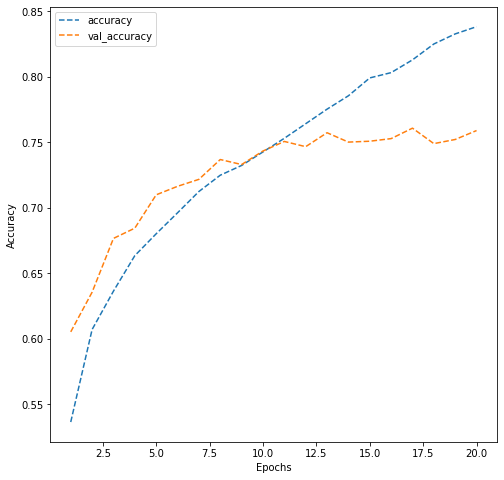

In [38]:
# Plotting the accuracy of the model 

dict_hist = history1.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [39]:
# Evaluating model1
model1.evaluate(test_set)

94/94 [==============================] - 9s 94ms/step - loss: 0.5837 - accuracy: 0.7393


[0.5837236046791077, 0.7392750382423401]

Found 3007 images belonging to 2 classes.
4/4 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.88      0.77      0.82        64
           1       0.79      0.89      0.84        64

    accuracy                           0.83       128
   macro avg       0.83      0.83      0.83       128
weighted avg       0.83      0.83      0.83       128



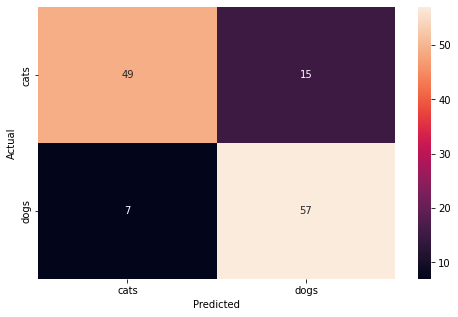

In [40]:
# Plotting the confusion matrix and generating a classification report for the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_set = datagen_test.flow_from_directory("/content/DaC Dataset/test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              classes = ['cats', 'dogs'],
                                                              shuffle = True) 
test_images, test_labels = next(test_set)


pred = model1.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['cats', 'dogs'], yticklabels = ['cats', 'dogs'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [46]:
# saving the model

model1.save(os.path.join("/content/models/Dogs_and_Cats_rec_model.h5"))